#**K-means Algorithm from Scratch.**
>*Comparison with KMeans Using Sklearn*


###**import statements**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

###**Defining Helper functions**

In [2]:
# defining helper function for our code.
def scaleDf(df,colList=[]):
    '''
    scaleDf -> this function scale the value of features in df using MinMaxScaler
    colList-> user can pass a list of features to scale otherwise all features are scaled
    '''
    scaler=MinMaxScaler()
    #if colList is not given then take all columns
    if(len(colList)==0):
        colList=df.columns
    df=pd.DataFrame(scaler.fit_transform(df[colList]),columns=colList)
    return df


def Clusters(df,labels):
    '''
    Cluters -> this function takes dataframe and labels as input and return the list of dataFrames
                of seperated clusters (based on labels).
    '''
    #Convert labels to numpy array (for simplicity purpose)
    labels=np.array(labels)
    #target is label name
    clusters=[]
    uniq_val=len(np.unique(labels))
    for i in range(uniq_val):
        clusters.append(df[labels==i])
    return clusters


def plotClusters(clusters):
    '''
    plotClusters -> it takes a list of DataFrames(clusters) where every dataFrame is a cluster and plot it using scatter plot
    '''
    random.seed(408) #setting seed of random
    #generating random colors for each clusters
    if(len(clusters)>7):
        colors=[(random.randint(0,255)/255,random.randint(0,255)/255,random.randint(0,255)/255) for i in range(len(clusters))]
    else:
        colors=['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i,cluster in enumerate(clusters):
        cols=cluster.columns
        plt.scatter(cluster[cols[0]],cluster[cols[1]],color=colors[i],label=str(i))
        plt.xlabel(cols[0])
        plt.ylabel(cols[1])
    plt.legend()
    plt.plot()



###**Distance class definition**
>for calculating different type of distances between two n-dimensional points

In [3]:
class Distance:
    def __init__(self,algo='eucledian',Power=2):
        self.algo=algo
        # Power -> power value used for MinKowski distance
        self.P=Power

    def calc(self,p1,p2):
        '''
        Input
            p1,p2 -> numpy array of size d denoting  d-dimenstional points
        Output
            it returns the distance(in np.float64 dtype) based on the algo
        '''
        if self.algo=='minkowski':
            return self.minkowskiDist(p1,p2,self.P)
        elif self.algo=='eucledian':
            return self.eucledianDist(p1,p2)
        elif self.algo=='manhatten':
            return self.manhattenDist(p1,p2)
    
    def algo(self):
        '''
         this function returns the names of algo's that we can use in this class
        '''
        return ['eucledian','minkowski','manhatten']

    def minkowskiDist(self,p1,p2,P):
        return np.power(np.sum(np.power(p2-p1,P)),1/P)
    
    def eucledianDist(self,p1,p2):
        return np.sqrt(np.sum(np.square(p2-p1)))
    
    def manhattenDist(self,p1,p2):
        return np.sum(np.absolute(p2-p1))

###**K-means Class Implementation**

In [4]:
# (Distance class must be there and executed for working of this K_Means Class)
# My K_Means class starts here
class K_Means:
    def __init__(self,n_clusters=4,Distance_algo='eucledian',Power=2,n_init=1, max_iter=300,random_state=100):
        self.K=n_clusters
        self.Distance_algo=Distance_algo
        self.Power=Power #Power used for Minkowski distance
        self.n_init=10
        self.max_iter=max_iter
        self.random_state=random_state
        #additional data attribute (similar to sklearn Kmeans)
        self.cluster_centers_=np.array([])
        self.labels_=np.array([])
        self.inertia_=0
        self.n_iter_=0
        self.n_features_in_=0
        self.feature_names_in_=np.array([])
    
    def get_params(self):
        '''
        Returns Kmeans Model parameters with their values
        '''
        params=dict()
        params['n_clusters']=self.K
        params['Distance_algo']=self.Distance_algo
        params['Power']=self.Power
        params['n_init']=self.n_init
        params['max_iter']=self.max_iter
        params['max_iter']=self.max_iter
        params['random_state']=self.random_state
        return params

    def fit(self,df):
        '''
        Input
            df -> a data frame containing n data points with d features each
            random_state -> a random_state value to be used as seed for random
        Output
            the predicted cluster number corresponding to each point
        '''
        # creating points
        pts=df.to_numpy(copy=True) #convert df to np array
        n_init=self.n_init
        '''
        n_init -> Number of time the k-means algorithm will be run with different centroid seeds.
        The final results will be the best output of n_init consecutive runs in terms of inertia.
        '''
        min_inertia=np.inf #store the minimum inertia across runs
        while n_init:
            # initially choose k random points as centroids
            centroids=pts[self.K_uniq_rand_ints(self.K,len(pts),self.random_state+n_init)]
            # clusters array will store cluster corresponding to every point
            # initially starts cluster corresponding to every point as -1
            clusters=[-1 for i in range(len(pts))]

            # Iterating and assigning centroids untill no change in centroids
            iteration=0
            while True:
                # Assign point to nearest Centroid
                reassign_cnt=self.AssignCentroids(pts,centroids,clusters)
                # update centroids based on reassignment
                self.updateCentroids(pts,centroids,clusters)
                # Loop break condition
                if reassign_cnt==0 or iteration>self.max_iter:
                    break
                iteration+=1
            # decrease n_init
            n_init-=1
            # calculating inertia
            inertia=self.getInertia(pts,clusters,centroids)
            # if clustering is better then update the parameters
            if inertia<min_inertia:
                min_inertia=inertia
                # store attribute values
                self.cluster_centers_=centroids
                self.labels_=clusters
                self.n_iter_=iteration
                self.n_features_in_=len(pts[0])
                self.feature_names_in_=np.array(df.columns)
                self.inertia_=min_inertia
        #return the cluster labels        
        return self.labels_

    def AssignCentroids(self,pts,centroids,clusters):
        '''
        Input:
          pts -> data points
          centroids -> Current cluster centroids
          clusters -> clusters[i] is the cluster number of pts[i] point.
        Output:
          it returns number of cluster reassignment (no. of points for which cluster number changed)
        '''
        # reassign_ptr counts the reassignment of clusters
        reassign_ptr=0
        for i,point in enumerate(pts):
            '''
             for every point we find the nearest cluster centroid and if it is diffrent
             than previous then we update the cluster no. of the point and increase the reassignment pointer
            '''
            nearest_cluster_num=self.get_nearest_centroid(point,centroids)
            if nearest_cluster_num!=clusters[i]:
                clusters[i]=nearest_cluster_num
                reassign_ptr+=1
        return reassign_ptr

    def get_nearest_centroid(self,point,centroids):
        '''
        Input:
          point -> the point of observation
          centroids -> list of all centroids points
        Output
          it return the index number of nearest centroid point from the given point
        '''
        mindist=np.inf
        # initialize the distance class with a particular algo
        distance=Distance(algo=self.Distance_algo,Power=self.Power)
        for idx,centroid in enumerate(centroids):
            dist=distance.calc(point,centroid)
            if dist<mindist:
                min_dist_idx=idx
                mindist=dist
        return min_dist_idx
      
    def updateCentroids(self,pts,centroids,clusters):
        '''
        Input
          pts -> data points
          centroids -> centroid points(that needs to be updated)
          clusters-> cluster array of points after reassignment
        Output
          returns nothing.
          its Updtates the centroid points based on the Cluster array.
          i.e centroids[i]=mean of all points have cluster number=i
        '''
        for cluster_num in np.unique(clusters):
            #get all points with cluster value
            cluster_points=pts[np.where(clusters==cluster_num)]
            #update the centroid
            centroids[cluster_num]=cluster_points.mean(axis=0)

    def squared_distance_sum(self,points,centroid):
        '''
        this function returns the sum of square of distance of 
        every point in points from given centroid
        '''
        distance=Distance(algo=self.Distance_algo,Power=self.Power)
        sum_squared_dist=0
        for point in points:
            sum_squared_dist+=np.square(distance.calc(point,centroid))
        return sum_squared_dist

    def getInertia(self,pts,clusters,centroids):
        '''
        Input 
          pts -> data points
          clusters -> cluster number corresponding to data points
          centroids -> cluster centers
        Output
          returns sum of squared distace from every point to there assigned cluster center
        '''
        total_squared_dist=0
        for cluster_num in np.unique(clusters):
            cluster_points=pts[np.where(clusters==cluster_num)]
            centroid=centroids[cluster_num]
            total_squared_dist+=self.squared_distance_sum(cluster_points,centroid)
        return total_squared_dist

    def predict(self,test_df):
        '''
        (prerequisite -> fit already executed (model already built))
        Input :
            df_test -> test data points
        Ouput:
            returns Cluster number corresponding to each test data point
        '''
        # Print error if models is prerequisite not satisfied
        if(self.n_iter_==0):
            print("\tPlease Contruct and Fit the Model First (Run the Fit method)\n")
            return np.array([])
        test_pts=test_df.to_numpy(copy=True) #convert test_df to np array
        labels=[-1 for i in range(len(test_pts))]
        for i,point in enumerate(test_pts):
            labels[i]=self.get_nearest_centroid(point,self.cluster_centers_)
        return labels
    
    def specs(self):
        '''
        return Model Specifications (inertia and No. of features on which model trained )
        '''
        specs=dict()
        specs['inertia_']=self.inertia_
        specs['n_features_in_']=self.n_features_in_
        return specs


    # Helper Functions
    def K_uniq_rand_ints(self,K,N,random_state):
        '''
        this function takes integer N as input and it generates K unique
        integer values in range [0,N).
        it return a numpy array containing unique random values
        '''
        # we use default_rng to construct a random generator using seed(its new method)
        # in this function we use 2 layer of randomness
        rng = np.random.default_rng(random_state)
        idxs=np.arange(N)
        rng.shuffle(idxs)
        choosed_idxs=rng.choice(N,K,replace=False)
        return idxs[choosed_idxs]

# My K_Means class ends here

###**Loading Data and Refining**

In [5]:
# Loading iris dataset from pandas
irisdata=load_iris()

In [6]:
irisdata.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [7]:
# storing iris dataset in pd DataFrame format in maindf
maindf=pd.DataFrame(data=irisdata.data,columns=irisdata.feature_names)

In [8]:
# Adding target column (label) in our maindf
maindf["target"]=irisdata.target

In [9]:
# view of maindf
maindf.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
# Finding the 2 most relevant features with which our label is closely correlated
maindf.corr()
# we can see using correlation matrix that 2 features are petal length (cm) & petal width (cm)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


In [11]:
# storing the original (Given) labels seperately
# beacuse we are doing unsupervised learning so we do not require labels.
labels=maindf['target']

# Creating new dataframe 'df' with only our 2 most important features
df=maindf.iloc[:,2:4]

# changing column names of df for simplicity purpose
col_names=['pl','pw'] #pl->petal length , pw-> petal width
df.columns=col_names

In [12]:
# View of df
df.head()

,pl,pw
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


In [13]:
# Scaling our both features using MinMaxScaler
df=scaleDf(df)

In [14]:
# View of df after scaling
df.head()

,pl,pw
0,0.067797,0.041667
1,0.067797,0.041667
2,0.050847,0.041667
3,0.084746,0.041667
4,0.067797,0.041667


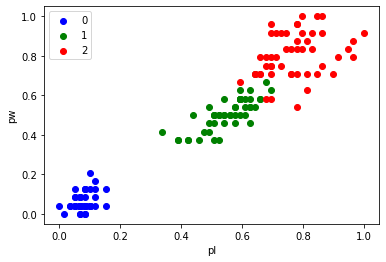

In [15]:
# Actual (Given data) clusters
given_clusters=Clusters(df,labels)
# plotting original cluters
plotClusters(given_clusters)

###**KMeans using of Sklearn Library**

In [16]:
#creating our KMeans model using sklearn
model=KMeans(n_clusters=3,random_state=0)
#fit the df in our model
model.fit(df)
# predicted labels by model
predicted_labels=pd.Series(model.labels_)

In [17]:
#Printing the sklearn KMeans Model specifications
print("sklearn KMeans model Specifications :-")
print("Model Inertia = ",model.inertia_)
print("Input Features = ",model.n_features_in_)
print("Iteration Runned = ",model.n_iter_)
print("")

sklearn KMeans model Specifications :-
Model Inertia =  1.701874688192097
Input Features =  2
Iteration Runned =  4



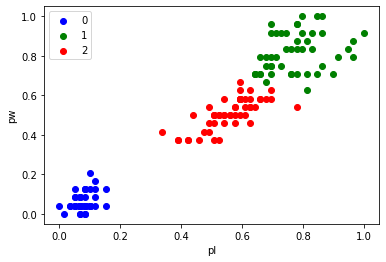

In [18]:
# predicted clusters
predicted_clusters=Clusters(df,predicted_labels)
# plotting predicted cluters using sklearn K-means model
'''
Colors of clusters are diffrent because K-means is Unsupervised learning so,
it autimatically put cluster names as 0,1,2...
'''
plotClusters(predicted_clusters)

###**K_Means Using Our Algorithm**

In [19]:
# Now Using Our K_Means Model
mymodel=K_Means(n_clusters=3)
#fit the df in our model
mymodel.fit(df)
# predicted labels by model
my_predicted_labels=mymodel.labels_

In [20]:
#Printing my K_Means Model specifications
print("My K_Means model Specifications :-")
print("Model Inertia = ",mymodel.inertia_)
print("Input Features = ",mymodel.n_features_in_)
print("Iteration Runned = ",mymodel.n_iter_)
print("")

My K_Means model Specifications :-
Model Inertia =  1.7018746881920963
Input Features =  2
Iteration Runned =  2



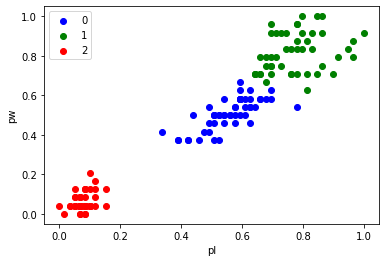

In [21]:
# predicted clusters using my K_Means model
my_predicted_clusters=Clusters(df,my_predicted_labels)
# plotting predicted cluters using my KMeans model
'''
Colors of clusters are diffrent because K_Means is Unsupervised learning so,
it autimatically put cluster names as 0,1,2...
'''
plotClusters(my_predicted_clusters)

***Any Improvments or Suggestions are welcomed***

###**Thank You** 🙂







Created by : Abhijit Kumar

Date : 12-11-2022

**©AbhijitKumar**